In [1]:
import os
import torch
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import torchvision.transforms.functional as F
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchsummary import summary
from torch.nn import BCEWithLogitsLoss

print(torch.__version__)

1.9.0


In [2]:
# see what GPU is currently being used

print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

1
0
NVIDIA GeForce GTX 1080 Ti


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**PREPARE DATASET**

The dataset consists of 19,200 images of cells but only 1,200 masks. The first step is to match up the images with their ground truth masks.

In [4]:
image_path = '/data1/rlubenow/BBBC005_v1_images/'
mask_path = '/data1/rlubenow/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/'

image_paths = sorted(os.listdir(image_path))
mask_paths = sorted(os.listdir(mask_path))

len(image_paths), len(mask_paths)

(19201, 1201)

In [5]:
image_paths[:5], mask_paths[:5]

(['.htaccess',
  'SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF'],
 ['.htaccess',
  'SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF'])

We want to remove the '.htaccess' file because it is of no use to us.

In [6]:
image_paths.remove('.htaccess')
mask_paths.remove('.htaccess')

len(image_paths), len(mask_paths)

(19200, 1200)

In [7]:
image_paths[:5], mask_paths[:5]

(['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s03_w1.TIF'],
 ['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s03_w1.TIF'])

Now we want to create a list of all images that have an associated mask:

In [8]:
new_list = sorted(list(set(image_paths) & set(mask_paths)))
len(new_list), type(new_list)

(1200, list)

In [9]:
new_list[:5]

['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
 'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
 'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
 'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
 'SIMCEPImages_A01_C1_F1_s03_w1.TIF']

Now that we have our list of 1200 images and their associated masks, lets split this into train and test sets:

In [10]:
train_list, test_list = train_test_split(new_list,
                                         test_size=0.1)

len(train_list), len(test_list)

(1080, 120)

Now lets visualize a couple of images and their ground truth segmentations:

In [11]:
img = tiff.imread(image_path + train_list[150])
mask = tiff.imread(mask_path + train_list[150])

img.shape, mask.shape

((520, 696), (520, 696))

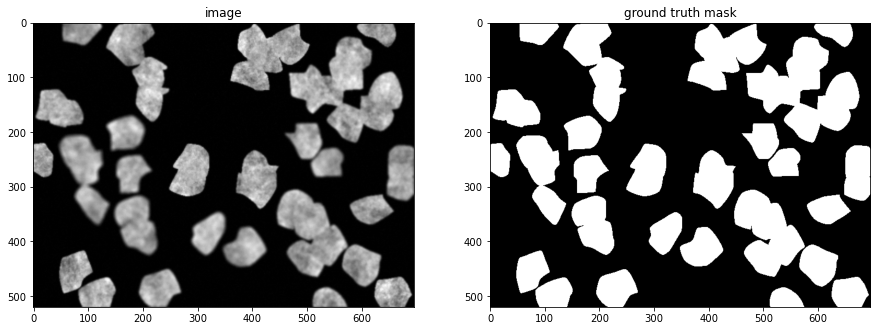

In [12]:
fig = plt.figure(figsize=(15,15))

fig.add_subplot(1,2,1)
plt.title('image')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,2,2)
plt.title('ground truth mask')
plt.imshow(mask, cmap='gray')

Here we can see a good example of an image and the ground truth mask. This is what we will be using to train our image segmentation model. The next step is to create a dataset and a dataloader.

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    def __getitem__(self, i):
        # grab the image path from the current index
        imagePath = self.imagePaths[i]
        maskPath = self.maskPaths[i]

        image = tiff.imread(image_path + imagePath)
        mask = tiff.imread(mask_path + maskPath)
        
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return image, mask

In [14]:
train_batch_size = 64
test_batch_size = 64
img_size = 128

transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((img_size, img_size)),
                                 transforms.ToTensor()])

In [15]:
## TRAIN DATASET
train_dataset = SegmentationDataset(train_list, train_list, transforms)

train_loader = DataLoader(train_dataset, 
                          batch_size = train_batch_size, 
                          shuffle = True)

## TEST DATASET
test_dataset = SegmentationDataset(test_list, test_list, transforms)

test_loader = DataLoader(test_dataset, 
                         batch_size = test_batch_size, 
                         shuffle = True)

In [16]:
trainImg, trainLabels = next(iter(train_loader))
print('trainImg shape: ', trainImg.shape), print('trainLabels shape: ', trainLabels.shape)

print('----------------------------------------------------')

testImg, testLabels = next(iter(test_loader))
print('testImg shape: ', testImg.shape), print('testLabels shape: ', testLabels.shape)

trainImg shape:  torch.Size([64, 1, 128, 128])
trainLabels shape:  torch.Size([64, 1, 128, 128])
----------------------------------------------------
testImg shape:  torch.Size([64, 1, 128, 128])
testLabels shape:  torch.Size([64, 1, 128, 128])


(None, None)

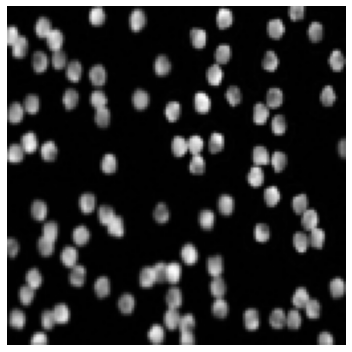

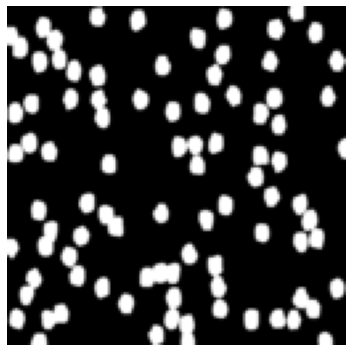

In [17]:
batch_num = 7

ts.show(trainImg[batch_num,:,:,:], figsize = (5, 5))
ts.show(trainLabels[batch_num,:,:,:], figsize = (5, 5))

Now we have our dataloaded into train and test loaders, it is time to build our model.

**Define UNet model**

In [18]:
import torch.nn as nn

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [19]:
model = UNet(n_channels=1, n_classes=1).float()
model.to(device)

summary(model, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
       double_conv-7         [-1, 64, 128, 128]               0
            inconv-8         [-1, 64, 128, 128]               0
         MaxPool2d-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

/rhome/rlubenow/miniconda3/envs/prot_loc/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)
    

def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())


def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

In [21]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = Adam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [62]:
# number of epochs to train the model
n_epochs = 32
train_loss_list = []
valid_loss_list = []
train_dice_list = []
val_dice_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        train_dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item() ## train dice cof
        train_dice_score +=  train_dice_cof * data.size(0)
            
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(test_loader, postfix={"test_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
            val_dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            val_dice_score +=  val_dice_cof * data.size(0)
            
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_dice_score = train_dice_score/len(train_loader.dataset)
    val_dice_score = val_dice_score/len(test_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_dice_list.append(train_dice_score)
    val_dice_list.append(val_dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_capstone.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.188, dice_score=0.901]


Epoch: 1  Training Loss: 0.172924  Validation Loss: 0.186965 Dice Score: 0.902881
Validation loss decreased (inf --> 0.186965).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.147, dice_score=0.921]


Epoch: 2  Training Loss: 0.132170  Validation Loss: 0.145262 Dice Score: 0.923534
Validation loss decreased (0.186965 --> 0.145262).  Saving model ...


100%|█████████████████████████| 2/2 [00:02<00:00,  1.40s/it, valid_loss=0.131, dice_score=0.93]


Epoch: 3  Training Loss: 0.127767  Validation Loss: 0.125942 Dice Score: 0.931056
Validation loss decreased (0.145262 --> 0.125942).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.43s/it, valid_loss=0.129, dice_score=0.935]


Epoch: 4  Training Loss: 0.128068  Validation Loss: 0.121640 Dice Score: 0.938251
Validation loss decreased (0.125942 --> 0.121640).  Saving model ...


100%|█████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.124, dice_score=0.93]


Epoch: 5  Training Loss: 0.124064  Validation Loss: 0.121188 Dice Score: 0.935477
Validation loss decreased (0.121640 --> 0.121188).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.119, dice_score=0.936]


Epoch: 6  Training Loss: 0.122539  Validation Loss: 0.120470 Dice Score: 0.935165
Validation loss decreased (0.121188 --> 0.120470).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.127, dice_score=0.925]


Epoch: 7  Training Loss: 0.122016  Validation Loss: 0.121086 Dice Score: 0.933830


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.126, dice_score=0.935]


Epoch: 8  Training Loss: 0.120853  Validation Loss: 0.119101 Dice Score: 0.935864
Validation loss decreased (0.120470 --> 0.119101).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.42s/it, valid_loss=0.114, dice_score=0.939]


Epoch: 9  Training Loss: 0.120670  Validation Loss: 0.118363 Dice Score: 0.936866
Validation loss decreased (0.119101 --> 0.118363).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.118, dice_score=0.936]


Epoch: 10  Training Loss: 0.120191  Validation Loss: 0.118306 Dice Score: 0.936487
Validation loss decreased (0.118363 --> 0.118306).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.38s/it, valid_loss=0.119, dice_score=0.932]


Epoch: 11  Training Loss: 0.119639  Validation Loss: 0.117975 Dice Score: 0.936799
Validation loss decreased (0.118306 --> 0.117975).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.118, dice_score=0.939]


Epoch: 12  Training Loss: 0.119738  Validation Loss: 0.117153 Dice Score: 0.938016
Validation loss decreased (0.117975 --> 0.117153).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.40s/it, valid_loss=0.117, dice_score=0.937]


Epoch: 13  Training Loss: 0.119652  Validation Loss: 0.117730 Dice Score: 0.937240


100%|█████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.12, dice_score=0.937]


Epoch: 14  Training Loss: 0.119670  Validation Loss: 0.117218 Dice Score: 0.938871


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.123, dice_score=0.939]


Epoch: 15  Training Loss: 0.119446  Validation Loss: 0.117036 Dice Score: 0.939194
Validation loss decreased (0.117153 --> 0.117036).  Saving model ...


100%|█████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.12, dice_score=0.936]


Epoch: 16  Training Loss: 0.118982  Validation Loss: 0.116972 Dice Score: 0.937936
Validation loss decreased (0.117036 --> 0.116972).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.40s/it, valid_loss=0.117, dice_score=0.933]


Epoch: 17  Training Loss: 0.118803  Validation Loss: 0.117550 Dice Score: 0.937604


100%|█████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.118, dice_score=0.94]


Epoch: 18  Training Loss: 0.118681  Validation Loss: 0.116517 Dice Score: 0.938322
Validation loss decreased (0.116972 --> 0.116517).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.117, dice_score=0.943]


Epoch: 19  Training Loss: 0.118897  Validation Loss: 0.117396 Dice Score: 0.937227


100%|████████████████████████| 2/2 [00:02<00:00,  1.40s/it, valid_loss=0.114, dice_score=0.942]


Epoch: 20  Training Loss: 0.118982  Validation Loss: 0.116965 Dice Score: 0.938512


100%|████████████████████████| 2/2 [00:02<00:00,  1.42s/it, valid_loss=0.108, dice_score=0.941]


Epoch: 21  Training Loss: 0.119184  Validation Loss: 0.116832 Dice Score: 0.938376


100%|████████████████████████| 2/2 [00:02<00:00,  1.40s/it, valid_loss=0.118, dice_score=0.937]


Epoch: 22  Training Loss: 0.118793  Validation Loss: 0.116373 Dice Score: 0.938680
Validation loss decreased (0.116517 --> 0.116373).  Saving model ...


100%|█████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.116, dice_score=0.94]


Epoch: 23  Training Loss: 0.118419  Validation Loss: 0.116437 Dice Score: 0.938560


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.118, dice_score=0.939]


Epoch: 24  Training Loss: 0.118628  Validation Loss: 0.116315 Dice Score: 0.938645
Validation loss decreased (0.116373 --> 0.116315).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.109, dice_score=0.943]


Epoch: 25  Training Loss: 0.118312  Validation Loss: 0.116270 Dice Score: 0.938529
Validation loss decreased (0.116315 --> 0.116270).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.41s/it, valid_loss=0.112, dice_score=0.943]


Epoch: 26  Training Loss: 0.118332  Validation Loss: 0.116495 Dice Score: 0.938279


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.116, dice_score=0.938]


Epoch: 27  Training Loss: 0.118584  Validation Loss: 0.116301 Dice Score: 0.938406


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.117, dice_score=0.939]


Epoch: 28  Training Loss: 0.118535  Validation Loss: 0.116230 Dice Score: 0.938497
Validation loss decreased (0.116270 --> 0.116230).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.38s/it, valid_loss=0.118, dice_score=0.936]


Epoch: 29  Training Loss: 0.118290  Validation Loss: 0.116299 Dice Score: 0.938348


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.121, dice_score=0.939]


Epoch: 30  Training Loss: 0.118294  Validation Loss: 0.116262 Dice Score: 0.938267


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.121, dice_score=0.936]


Epoch: 31  Training Loss: 0.118390  Validation Loss: 0.116137 Dice Score: 0.938672
Validation loss decreased (0.116230 --> 0.116137).  Saving model ...


100%|████████████████████████| 2/2 [00:02<00:00,  1.39s/it, valid_loss=0.119, dice_score=0.939]

Epoch: 32  Training Loss: 0.118189  Validation Loss: 0.116173 Dice Score: 0.938476


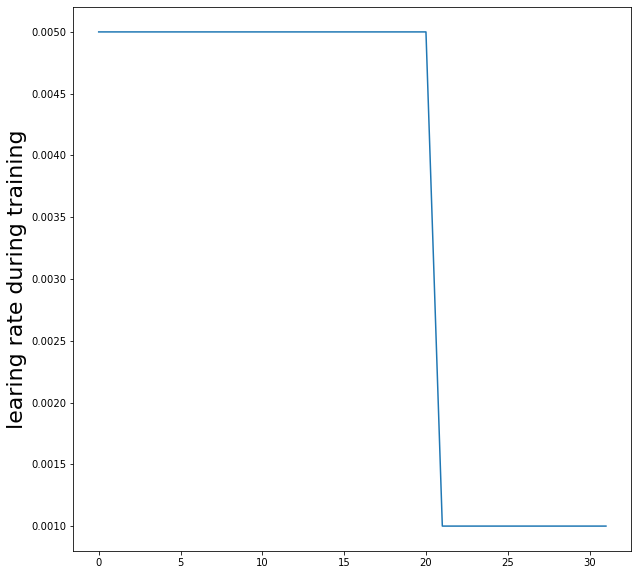

In [63]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

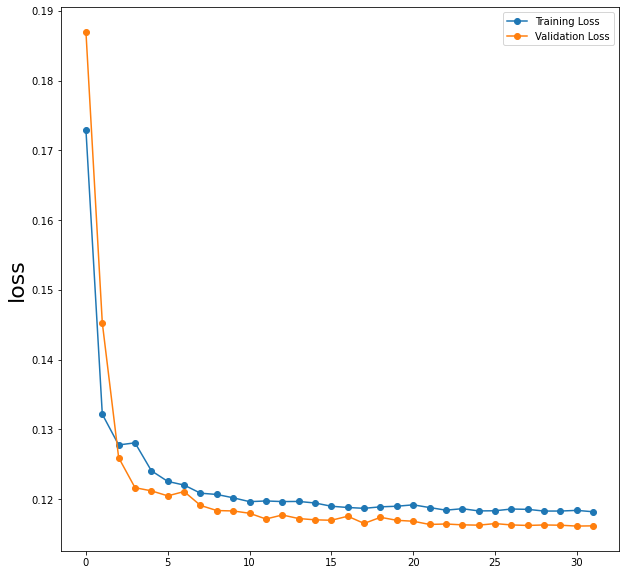

In [64]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

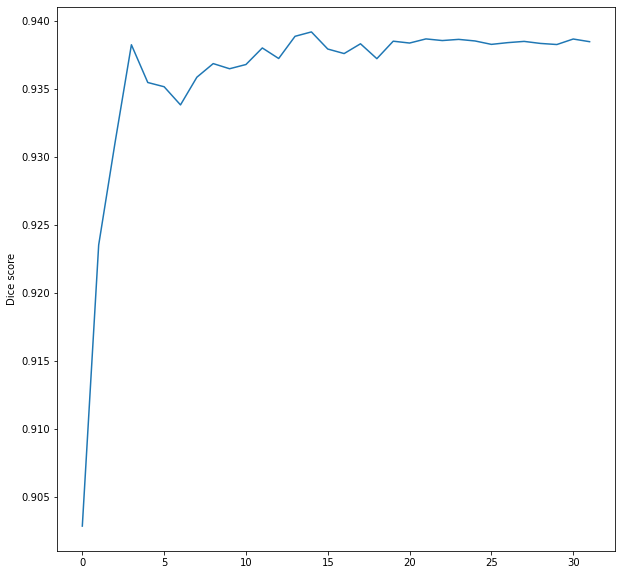

In [65]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

In [22]:
# load best model
model.load_state_dict(torch.load('model_capstone.pt'))
model.eval();

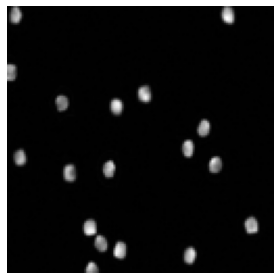

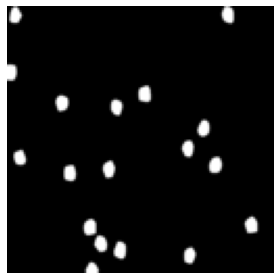

In [23]:
batch_num = 12

ts.show(testImg[batch_num,:,:,:])
ts.show(testLabels[batch_num,:,:,:])

In [24]:
outputs = model(testImg.to(device))
outputs.shape

torch.Size([64, 1, 128, 128])

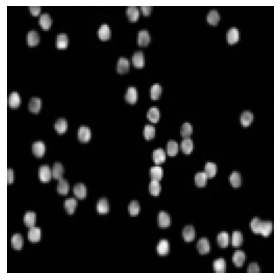

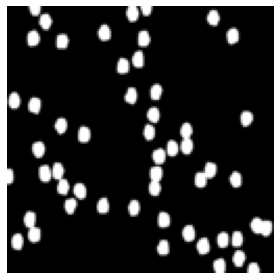

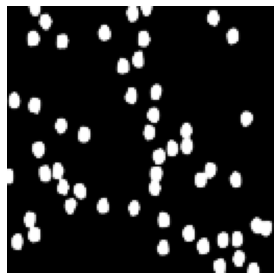

In [33]:
batch_num = 50

ts.show(testImg[batch_num])
ts.show(testLabels[batch_num])
ts.show(outputs[batch_num])